In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm
from carps.analysis.utils import get_color_palette, setup_seaborn, savefig, get_marker_palette
from dacboenv.experiment.collect_incumbents import add_metadata_to_dict
from omegaconf import OmegaConf
from tensorboard.backend.event_processing import event_accumulator


In [2]:
rundir = Path("../runsicml2")

tags = [
    "rollout/ep_len_mean",
    "rollout/ep_rew_mean",
    "train/entropy_loss",
    "train/value_loss",
    "train/policy_gradient_loss",
]

def scalar_to_df(ea, tag):
    events = ea.Scalars(tag)
    return pd.DataFrame({
        "step": [e.step for e in events],
        "value": [e.value for e in events],
        "tag": tag,
    })

rundirs = [p.parent for p in rundir.glob("*/*/*/*/ppo.log")]
logs = []
for rundir in tqdm.tqdm(rundirs, total=len(rundirs), desc="Loading PPO training logs..."):
    try:
        event_file = str(next(iter(rundir.glob("tensorboard/tb_log_2/events*"))))
    except StopIteration:
        event_file = str(next(iter(rundir.glob("tensorboard/tb_log_1/events*"))))
    ea = event_accumulator.EventAccumulator(
        event_file,
        size_guidance={
            event_accumulator.SCALARS: 0,  # load all scalar events
        },
    )
    ea.Reload()
    df = pd.concat([scalar_to_df(ea, tag) for tag in tags])

    cfg = OmegaConf.load(rundir / ".hydra/config.yaml")
    df = add_metadata_to_dict(df, cfg)
    df["architecture"] = df["optimizer_id"].map(lambda x: x.split("-")[1])
    df["obsnorm"] = df["optimizer_id"].map(lambda x: True if "norm" in x else False)
    logs.append(df)
logs = pd.concat(logs).reset_index(drop=True)
logs.to_parquet("traininglogs.parquet")


Loading PPO training logs...: 100%|██████████| 720/720 [03:25<00:00,  3.51it/s]


In [3]:
# print(logs.columns)
# smac_symbol = "SMAC"  #"🚂"    # "0️⃣"
# default_symbol = "Def"
# sawei_symbol = "SAWEI"  #"🚅"  #"1️⃣"
# dim_str = ""
# renaming = {
#     "reward_id": {
#         "symlogregret-SAWEI-P": f"symlogregret-{sawei_symbol}",
#         "symlogregret-SMAC3-BlackBoxFacade": f"symlogregret-{smac_symbol}",
#         "symlogregret-DefaultAction": f"symlogregret-{default_symbol}",
#         "episode_finished_scaled-SAWEI-P": f"eplen-{sawei_symbol}",
#         "episode_finished_scaled-SMAC3-BlackBoxFacade": f"eplen-{smac_symbol}",
#         "episode_finished_scaled-DefaultAction": f"eplen-{default_symbol}",
#     },
#     "instance_set_id": {
#         "bbob2d_fid8_3seeds": f"fid8{dim_str}",
#         "bbob2d_3seeds": f"bbob{dim_str}"
#     }
# }
# suffix = "_plot"
# for key, value in renaming.items():
#     logs[key + suffix] = logs[key].map(lambda x: value[x])
# logs["policy_id"] = "PPO-" + logs["reward_id" + suffix] + "-" + logs["instance_set_id" + suffix]

# reduce_seeds = False
# if not reduce_seeds:
#     logs["policy_id"] = logs["policy_id"] + "-" + logs["seed"].map(str)
# print(logs["policy_id"].unique())


In [4]:
# logs = pd.read_parquet("traininglogs.parquet")
import itertools
variant_axes = ["reward_id", "instance_set_id", "action_space_id", "observation_space_id", "architecture", "obsnorm", "reference_performance_id"]
variants = {k: list(logs[k].unique()) for k in variant_axes}
vals = list(variants.values())
combos = itertools.product(*vals)
variants

{'reward_id': ['episode_finished_scaled-DefaultAction',
  'episode_finished_scaled-SAWEI-P',
  'symlogregret-SAWEI-P',
  'symlogregret-DefaultAction'],
 'instance_set_id': ['bbob2d_fid8_3seeds', 'ackley2d_3seeds', 'bbob2d_3seeds'],
 'action_space_id': ['WEI-skip', 'WEI-cont', 'WEI-step'],
 'observation_space_id': ['sawei'],
 'architecture': ['MLP', 'RNN'],
 'obsnorm': [np.True_, np.False_],
 'reference_performance_id': ['DefaultAction', 'SAWEI-P']}

['rollout/ep_len_mean' 'rollout/ep_rew_mean' 'train/entropy_loss'
 'train/value_loss' 'train/policy_gradient_loss']


/tmp/ipykernel_3573554/3626979266.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  logs_to_plot = gdf[


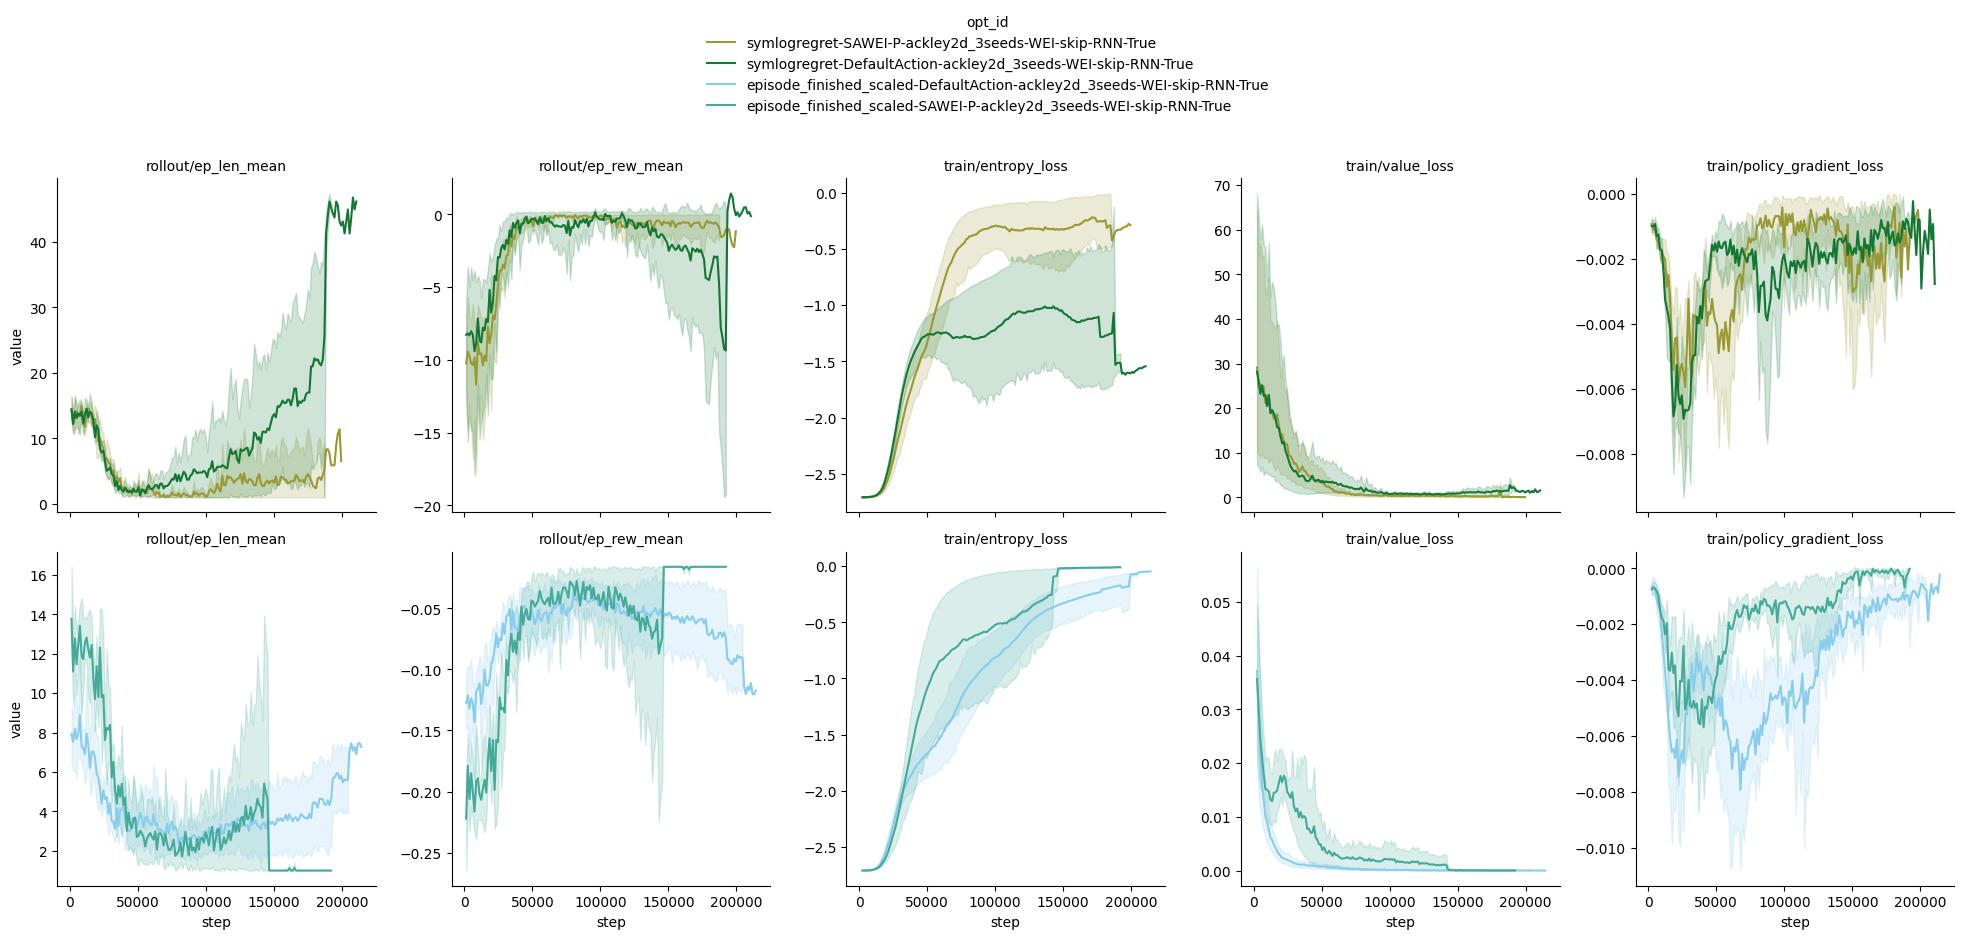

/tmp/ipykernel_3573554/3626979266.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  logs_to_plot = gdf[


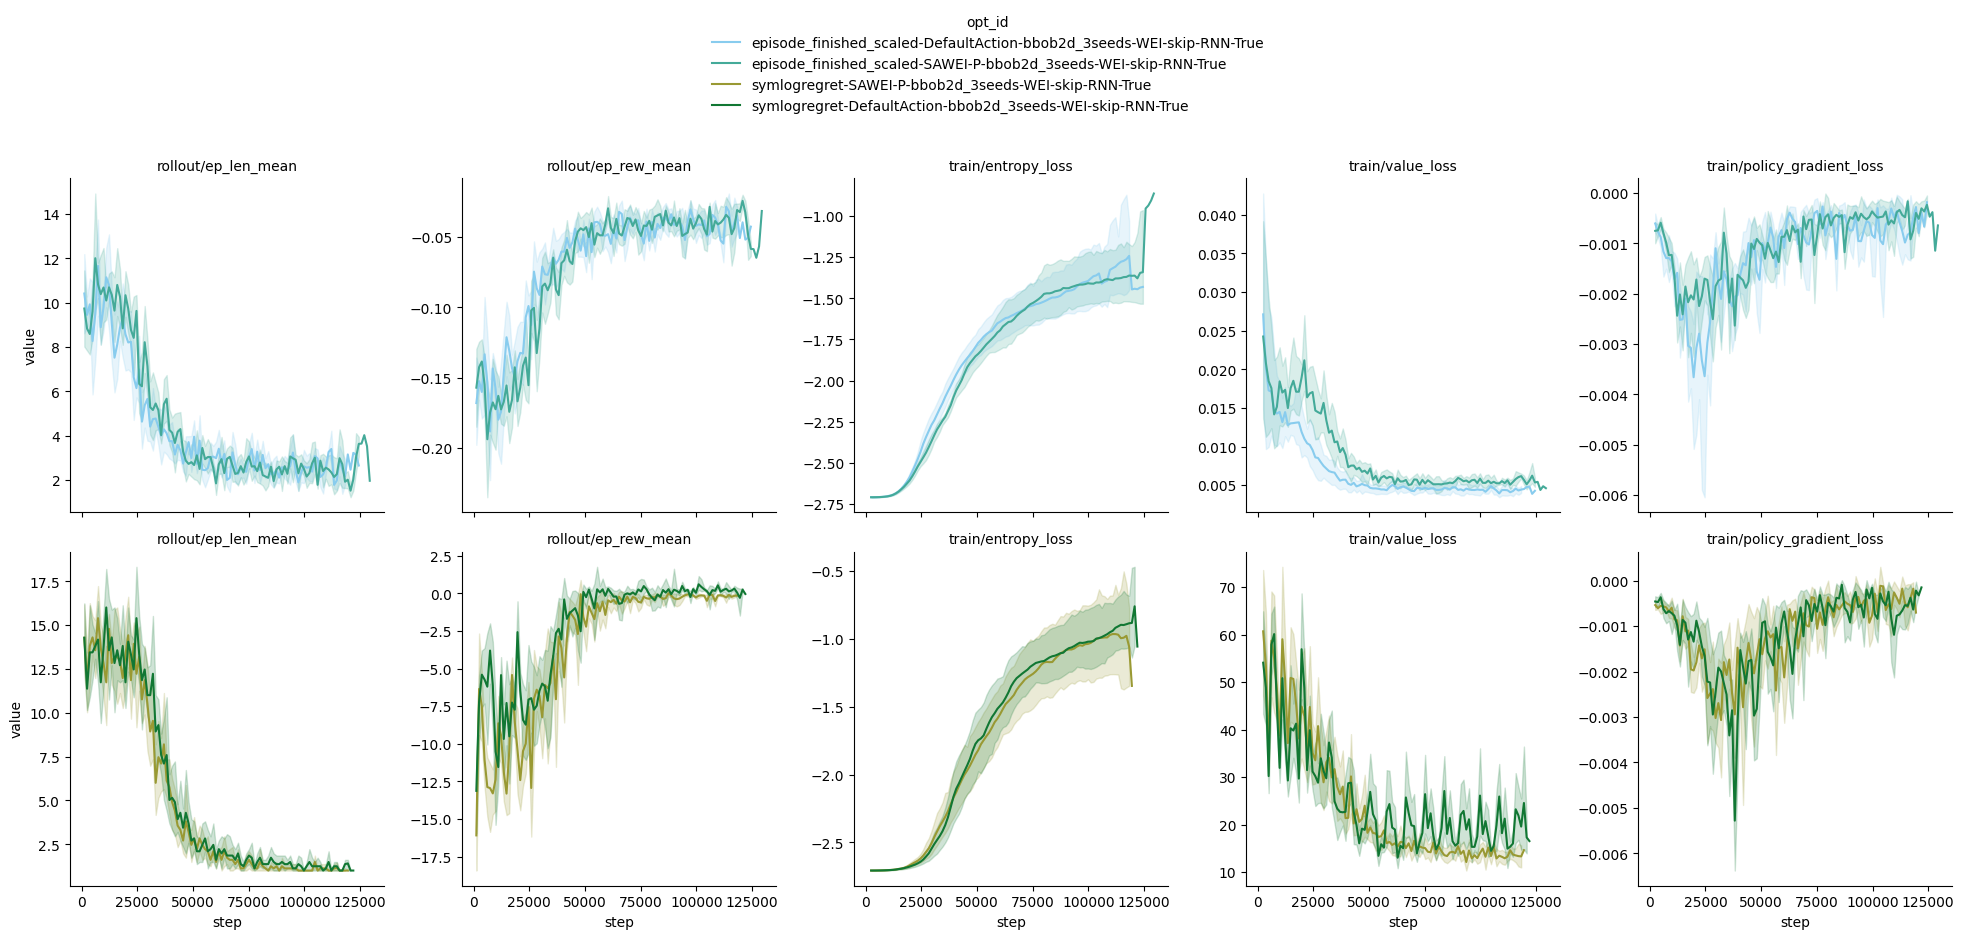

/tmp/ipykernel_3573554/3626979266.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  logs_to_plot = gdf[


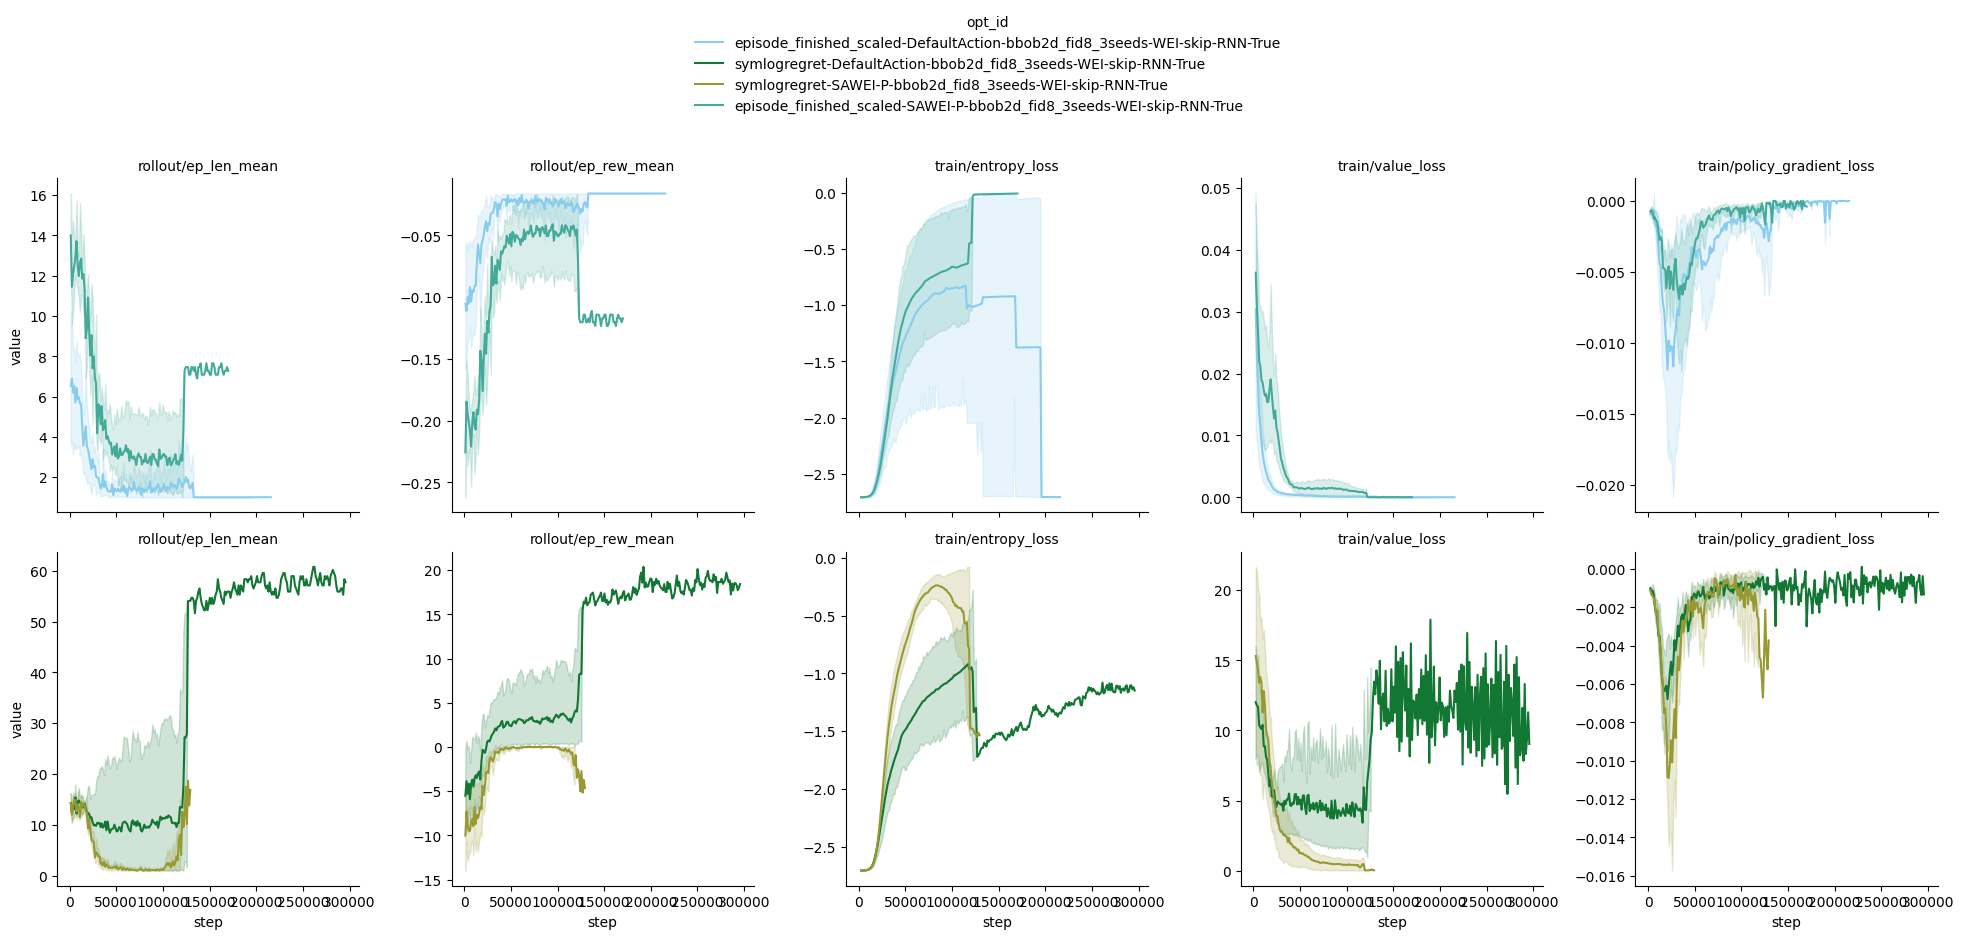

In [5]:

import numpy as np

tags_to_plot = [
    "rollout/ep_len_mean",
    "rollout/ep_rew_mean"
]
print(logs["tag"].unique())

keys = list(variants.keys())

# for combo in combos:
#     print(combo)

#     filter_ids = np.array([True] * len(logs))
#     for k, v in zip(keys, combo):
#         filter_ids = filter_ids & (logs[k] == v)
#     logs_to_plot = logs[filter_ids]

    # if len(logs_to_plot) == 0:
    #     print(f"Nothing found for {combo}")
    #     continue

logs["reward_id"] = logs["reward_id"].map(lambda x: x.split("-")[0])
logs["opt_id"] = logs["reward_id"] + "-" + logs["reference_performance_id"] + "-" + logs["instance_set_id"] + "-" + logs["action_space_id"] + "-" + logs["architecture"] + "-" + logs["obsnorm"].map(str)

for instance_set_id, gdf in logs.groupby("instance_set_id"):
    logs_to_plot = gdf[
        # (logs["reward_id"] == "episode_finished_scaled-SAWEI-P") \
        # (logs["reward_id"] == "episode_finished_scaled-DefaultAction") \
        # (logs["reward_id"] == "symlogregret-SAWEI-P") \
        # (logs["reward_id"] == "symlogregret-DefaultAction") \
         (logs["action_space_id"] == "WEI-skip") \
        & (logs["architecture"] == "RNN") \
        & (logs["obsnorm"] == True) \
    ]
    # logs_to_plot = gdf


    hue = "opt_id"
    hues = logs_to_plot[hue].unique()
    palette = get_color_palette(optimizers=hues)
    markers = get_marker_palette(optimizers=hues)
    g = sns.FacetGrid(
        logs_to_plot,
        col="tag",
        # col_wrap=max(5, len(tags_to_plot)),
        row="reward_id",
        sharex=True,
        sharey=False,
        height=4,
        hue=hue,
        palette=palette
    )
    # g.map_dataframe(sns.lineplot, x="step", y="value")
    g.map_dataframe(sns.lineplot, x="step", y="value", markers=markers, markevery=50000,
                    # estimator=None, units="seed",
                    )
    g.set_titles("{col_name}")
    g.add_legend(bbox_to_anchor=(0.5, 1.1))
    # g.figure.suptitle(combo)
    g.tight_layout()
    plt.show()

    # break





In [6]:
# logs_to_plot = logs[
#         (logs["tag"].isin(tags_to_plot)) \
#         # (logs["reward_id"].str.contains("ep")) \
#         (logs["reward_id"].str.contains("sym")) \
#         # & (logs["reward_id"].str.contains("SAWEI")) \
#         & (logs["reward_id"].str.contains("SMAC")) \
#         & (logs["instance_set_id"].str.contains("2d_3")) \
#         # & (logs["instance_set_id"].str.contains("fid8")) \
#     ]

# df["value_smooth"] = (
#     df.groupby("tag")["value"]
#       .transform(lambda x: x.ewm(alpha=0.1).mean())
# )l
# plt.figure(figsize=(12, 8))
# sns.lineplot(data=df, x="step", y="value_smooth", hue="tag")
# plt.title("Smoothed Training Metrics")
# plt.tight_layout()
# plt.show()